**Probability distributions in practice**

here, i want to explore/simulate some of the probability distributions from the recently published International brain laboratory data.
https://www.nature.com/articles/s41586-025-09226-1

The general task of the paper: Mice were trained to discriminate whether a visual stimulus, of different contrasts, appeared in the right or left visual field. Importantly, the prior probability that the stimulus appeared on the right side switched in a random and uncued manner between 0.2 and 0.8 in blocks of 20–100 trials. The general idea was that if the mice could construct an appropriate prior, their ability to perform in the task would significantly improve.

Particulary, I am interested in figure 1C. 
- On the x axis we have signed contrast. Negative values means stimulus was on the left (e.g. –1.0 = 100% contrast on the left, –0.25 = 25% contrast on the left) and positive right
- Y axis shows the probability that the mice chooses the right side.
- There are two summary curves present, one when the prior of the object appearing on the right is 0.2 (left blocks) and one when the prior of the object appearing on the right is 0.8 (right blocks)
- The key finding here is that at zero contrast (ambiguous evidence), the animal’s choices shift toward the block prior suggesting that the prior is an important component of the decision making of mice.
- This is an example of a psychometric function derived from bernoulli draws for each signed contrast value
- What I want to do is try and simulate trials where decisions are made perfectly in accordance to priors because the mice don't!
- We know that mice don't follow optimal priors because at 0 contrast the right block probability is not 0.8 and the left block probability is not 0.2.

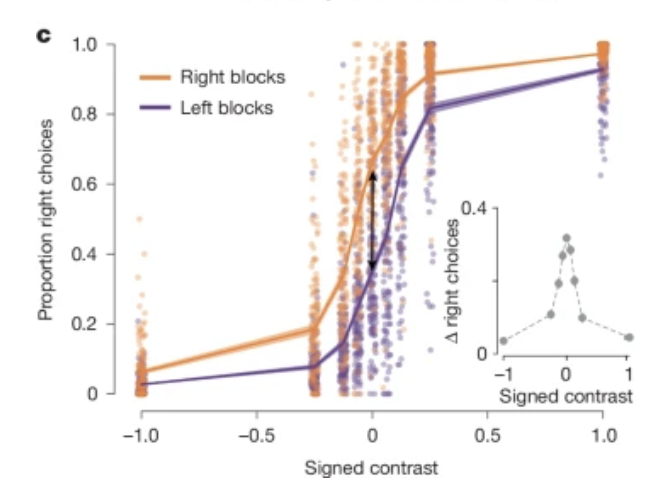

In [7]:
from IPython.display import Image
Image("Images/figure1c.png")

In order to generate psychometric curves for an ideal participant who acts perfectly according to the priors we will do the following

-  Define optimal_psychometric a Logistic function giving the optimal probability of choosing “right” given:
  
        x: signed contrast (negative = left, positive = right).
        prior: block prior P(\text{Right}).
        beta_c: slope (sensitivity to contrast).
        Adds prior bias as a log-odds offset.
- Compute “theoretical” psychometric curves:

  
        p_curve_08: Optimal curve with prior = 0.8.
        p_curve_02: Optimal curve with prior = 0.2.
- Define simulate_batch_means:

  
        For each contrast level, compute true P(Right).
        Simulate n_batches independent groups, each group = average of batch_size Bernoulli trials. Here we use a binomial distribution.
        Returns arrays of x positions (xs) and simulated mean proportions (ys).
- Simulate scatter points:

  
        x08, y08: simulated batch means for prior = 0.8.
        x02, y02: simulated batch means for prior = 0.2.

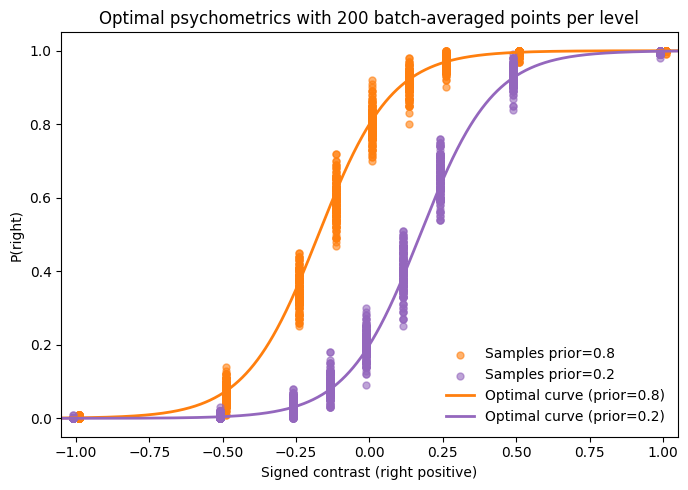

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# optimal psychometric
def optimal_psychometric(x, prior, beta_c=8.0):
    logit = np.log(prior / (1 - prior))
    p = 1 / (1 + np.exp(-(beta_c * x + logit)))
    return p

# signed contrasts used in the task
sign_contrast = np.array([-1.0, -0.5, -0.25, -0.125, 0.0, 0.125, 0.25, 0.5, 1.0])
xaxis = np.linspace(-1.05, 1.05, 801)

# theoretical curves
p_curve_08 = optimal_psychometric(xaxis, prior=0.8)
p_curve_02 = optimal_psychometric(xaxis, prior=0.2)

# --- simulate averages of 100-trial batches, 200 batches per level ---
rng = np.random.default_rng(123)

def simulate_batch_means(sign_contrast, prior, n_batches=200, batch_size=100):
    p = optimal_psychometric(sign_contrast, prior)
    xs, ys = [], []
    for xi, pi in zip(sign_contrast, p):
        # each batch = average of 100 Bernoulli trials
        means = rng.binomial(batch_size, pi, size=n_batches) / batch_size
        xs.extend([xi] * n_batches)
        ys.extend(means)
    return np.array(xs), np.array(ys)

x08, y08 = simulate_batch_means(sign_contrast, prior=0.8)
x02, y02 = simulate_batch_means(sign_contrast, prior=0.2)

# --- plot ---
plt.figure(figsize=(7,5))

# scatter simulated "batch-mean" points
plt.scatter(x08 + 0.01, y08, color="tab:orange", alpha=0.6, s=25, label="Samples prior=0.8")
plt.scatter(x02 - 0.01, y02, color="tab:purple", alpha=0.6, s=25, label="Samples prior=0.2")

# overlay theoretical curves
plt.plot(xaxis, p_curve_08, color="tab:orange", lw=2, label="Optimal curve (prior=0.8)")
plt.plot(xaxis, p_curve_02, color="tab:purple", lw=2, label="Optimal curve (prior=0.2)")

plt.xlabel("Signed contrast (right positive)")
plt.ylabel("P(right)")
plt.title("Optimal psychometrics with 200 batch-averaged points per level")
plt.ylim(-0.05, 1.05); plt.xlim(-1.05, 1.05)
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()